<a href="https://colab.research.google.com/github/sibat119/finetune-transformer-models/blob/main/finetune_bert_for_ner_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BERT Fine-Tuning with PyTorch for Named Entity Recognition task

Use BERT with the huggingface PyTorch library to quickly and efficiently fine-tune a model to get near state of the art performance in Named Entity Recognition. More broadly, I describe the practical application of transfer learning in NLP to create high performance models with minimal effort on a range of NLP tasks.

# 1. Setup

# 1.1. Using Colab GPU for Training

In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# 1.2. Installing the Hugging Face Library

In [2]:
!pip install transformers

     |████████████████████████████████| 2.3MB 7.5MB/s 
     |████████████████████████████████| 901kB 45.3MB/s 
     |████████████████████████████████| 3.3MB 46.6MB/s 


The code in this notebook is actually a simplified version of the [run_ner.py](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_ner.py) example script from huggingface. This `run_ner.py` also uses [utils_ner.py](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/utils_ner.py) file which we also followed for this finetuning process.

`run_ner.py` is a helpful utility which allows you to pick which NER task you want to run on, and which pre-trained model you want to use (you can see the list of possible models [here](https://github.com/huggingface/transformers/blob/e6cff60b4cbc1158fbd6e4a1c3afda8dc224f566/examples/run_glue.py#L69)). It also supports using either the CPU, a single GPU, or multiple GPUs. It even supports using 16-bit precision if you want further speed up.



Unfortunately, all of this configurability comes at the cost of *readability*. In this Notebook, we've simplified the code greatly and added plenty of comments to make it clear what's going on. 

# 2. Loading Conll-2003 Dataset

# 2.1. Download & Extract

We'll use the wget package to download the dataset to the Colab instance's file system.

In [3]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9675 sha256=f1d239bd198802d39d3d0e02b313fa3d75f7347fc3dcd235cad45bd87ca1d370
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [4]:
import wget
import os


# Download the file
if not os.path.exists('./conll'):
  print('Downloading dataset...')
  !wget -P conll/ "https://github.com/davidsbatista/NER-datasets/raw/master/CONLL2003/train.txt"
  !wget -P conll/ "https://github.com/davidsbatista/NER-datasets/raw/master/CONLL2003/test.txt"
  !wget -P conll/ "https://github.com/davidsbatista/NER-datasets/raw/master/CONLL2003/valid.txt"


--2021-06-07 04:21:07--  https://github.com/davidsbatista/NER-datasets/raw/master/CONLL2003/train.txt
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/davidsbatista/NER-datasets/master/CONLL2003/train.txt [following]
--2021-06-07 04:21:07--  https://raw.githubusercontent.com/davidsbatista/NER-datasets/master/CONLL2003/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3283418 (3.1M) [text/plain]
Saving to: ‘conll/train.txt’

train.txt           100%[===================>]   3.13M  --.-KB/s    in 0.08s   

2021-06-07 04:21:08 (37.9 MB/s) - ‘conll/train.txt’ saved [3283418/3283418]

--202

In [5]:
class InputExample(object):
    """A single training/test example for token classification."""

    def __init__(self, guid, words, labels):
        """Constructs a InputExample.
        Args:
            guid: Unique id for the example.
            words: list. The words of the sequence.
            labels: (Optional) list. The labels for each word of the sequence. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.words = words
        self.labels = labels


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_ids):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids

In [6]:
def read_examples_from_file(data_dir, mode):
    file_path = os.path.join(data_dir, "{}.txt".format(mode))
    guid_index = 1
    examples = []
    with open(file_path, encoding="utf-8") as f:
        words = []
        labels = []
        for line in f:
            if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                if words:
                    examples.append(InputExample(guid="{}-{}".format(mode, guid_index),
                                                 words=words,
                                                 labels=labels))
                    guid_index += 1
                    words = []
                    labels = []
            else:
                splits = line.split(" ")
                words.append(splits[0])
                if len(splits) > 1:
                    labels.append(splits[-1].replace("\n", ""))
                else:
                    # Examples could have no label for mode = "test"
                    labels.append("O")
        if words:
            examples.append(InputExample(guid="%s-%d".format(mode, guid_index),
                                         words=words,
                                         labels=labels))
    return examples

In [7]:
def convert_examples_to_features(examples,
                                 label_list,
                                 max_seq_length,
                                 tokenizer):
    """ Loads a data file into a list of `InputBatch`s
        `cls_token_at_end` define the location of the CLS token:
            - False (Default, BERT/XLM pattern): [CLS] + A + [SEP] + B + [SEP]
            - True (XLNet/GPT pattern): A + [SEP] + B + [SEP] + [CLS]
        `cls_token_segment_id` define the segment id associated to the CLS token (0 for BERT, 2 for XLNet)
    """

    label_map = {label: i for i, label in enumerate(label_list)}
    cls_token="[CLS]"
    cls_token_segment_id=1
    sep_token="[SEP]"
    sep_token_extra=False
    pad_on_left=False
    pad_token=0
    pad_token_segment_id=0
    pad_token_label_id=-1
    sequence_a_segment_id=0
    mask_padding_with_zero=True
    cls_token_at_end = False

    features = []
    for (ex_index, example) in enumerate(examples):
        # if ex_index % 10000 == 0:
        #     logger.info("Writing example %d of %d", ex_index, len(examples))

        tokens = []
        label_ids = []
        for word, label in zip(example.words, example.labels):
            word_tokens = tokenizer.tokenize(word)
            tokens.extend(word_tokens)
            # Use the real label id for the first token of the word, and padding ids for the remaining tokens
            label_ids.extend([label_map[label]] + [pad_token_label_id] * (len(word_tokens) - 1))

        # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
        special_tokens_count = 3 if sep_token_extra else 2
        if len(tokens) > max_seq_length - special_tokens_count:
            tokens = tokens[:(max_seq_length - special_tokens_count)]
            label_ids = label_ids[:(max_seq_length - special_tokens_count)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids:   0   0  0    0    0     0       0   0   1  1  1  1   1   1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids:   0   0   0   0  0     0   0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens += [sep_token]
        label_ids += [pad_token_label_id]
        if sep_token_extra:
            # roberta uses an extra separator b/w pairs of sentences
            tokens += [sep_token]
            label_ids += [pad_token_label_id]
        segment_ids = [sequence_a_segment_id] * len(tokens)

        if cls_token_at_end:
            tokens += [cls_token]
            label_ids += [pad_token_label_id]
            segment_ids += [cls_token_segment_id]
        else:
            tokens = [cls_token] + tokens
            label_ids = [pad_token_label_id] + label_ids
            segment_ids = [cls_token_segment_id] + segment_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            input_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + input_mask
            segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
            label_ids = ([pad_token_label_id] * padding_length) + label_ids
        else:
            input_ids += ([pad_token] * padding_length)
            input_mask += ([0 if mask_padding_with_zero else 1] * padding_length)
            segment_ids += ([pad_token_segment_id] * padding_length)
            label_ids += ([pad_token_label_id] * padding_length)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        assert len(label_ids) == max_seq_length

        # if ex_index < 5:
        #     logger.info("*** Example ***")
        #     logger.info("guid: %s", example.guid)
        #     logger.info("tokens: %s", " ".join([str(x) for x in tokens]))
        #     logger.info("input_ids: %s", " ".join([str(x) for x in input_ids]))
        #     logger.info("input_mask: %s", " ".join([str(x) for x in input_mask]))
        #     logger.info("segment_ids: %s", " ".join([str(x) for x in segment_ids]))
        #     logger.info("label_ids: %s", " ".join([str(x) for x in label_ids]))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_ids=label_ids))
    return features


def get_labels(path):
    if path:
        with open(path, "r") as f:
            labels = f.read().splitlines()
        if "O" not in labels:
            labels = ["O"] + labels
        return labels
    else:
        return ["O", "B-MISC", "I-MISC",  "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC"]

In [8]:
training_examples = read_examples_from_file('./conll/', 'train')
validation_examples = read_examples_from_file('./conll/', 'valid')
testing_examples = read_examples_from_file('./conll/', 'test')

print('\n\n---------- training examples -----------')
for example in training_examples[:5]:
  print(example.words, example.labels)

print('\n\n---------- validation examples -----------')
for example in validation_examples[:5]:
  print(example.words, example.labels)


print('\n\n---------- testing examples -----------')
for example in testing_examples[:5]:
  print(example.words, example.labels)



---------- training examples -----------
['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'] ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']
['Peter', 'Blackburn'] ['B-PER', 'I-PER']
['BRUSSELS', '1996-08-22'] ['B-LOC', 'O']
['The', 'European', 'Commission', 'said', 'on', 'Thursday', 'it', 'disagreed', 'with', 'German', 'advice', 'to', 'consumers', 'to', 'shun', 'British', 'lamb', 'until', 'scientists', 'determine', 'whether', 'mad', 'cow', 'disease', 'can', 'be', 'transmitted', 'to', 'sheep', '.'] ['O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['Germany', "'s", 'representative', 'to', 'the', 'European', 'Union', "'s", 'veterinary', 'committee', 'Werner', 'Zwingmann', 'said', 'on', 'Wednesday', 'consumers', 'should', 'buy', 'sheepmeat', 'from', 'countries', 'other', 'than', 'Britain', 'until', 'the', 'scientific', 'advice', 'wa

# 3. Tokenization & Input Formatting

# 3.1. BERT Tokenizer

To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.

In [38]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, cache_dir=None)

Loading BERT tokenizer...


In [39]:
from torch.nn import CrossEntropyLoss
label_list = get_labels('')
max_seq_length = 64
num_labels = len(label_list)
# Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
pad_token_label_id = CrossEntropyLoss().ignore_index
print(label_list, pad_token_label_id)

['O', 'B-MISC', 'I-MISC', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'] -100


In [40]:
train_features = convert_examples_to_features(training_examples, label_list, max_seq_length,tokenizer)
valid_features = convert_examples_to_features(validation_examples, label_list, max_seq_length,tokenizer)
test_features = convert_examples_to_features(testing_examples, label_list, max_seq_length,tokenizer)


In [41]:
print(training_examples[0].words)
print(train_features[0].input_ids)
print(train_features[0].segment_ids)
print(train_features[0].input_mask)
print(train_features[0].label_ids)

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
[101, 7327, 19164, 2446, 2655, 2000, 17757, 2329, 12559, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[-1, 5, 0, 1, 0, 0, 0, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


In [42]:
# Convert to Tensors and build dataset
from torch.utils.data import TensorDataset
def convert_feature_to_tensor(features):
  all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
  all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
  all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
  all_label_ids = torch.tensor([f.label_ids for f in features], dtype=torch.long)

  dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
  return dataset

In [43]:
train_dataset = convert_feature_to_tensor(train_features)
valid_dataset = convert_feature_to_tensor(valid_features)
test_dataset = convert_feature_to_tensor(test_features)

We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory

In [44]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            valid_dataset, # The validation samples.
            sampler = SequentialSampler(valid_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Train Our Classification Model

# 4.1. BertForTokenClassification

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. 

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.  

Here is the current list of classes provided for fine-tuning:
* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* BertForSequenceClassification
* **BertForTokenClassification** - The one we'll use.
* BertForQuestionAnswering

The documentation for these can be found under [here](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html).

In [45]:
from transformers import BertForTokenClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top.
cache_dir = None 
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=num_labels, 
                                    cache_dir=cache_dir if cache_dir else None)
model = BertForTokenClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    config=config,
    cache_dir=cache_dir if cache_dir else None
)

# Tell pytorch to run this model on the GPU.
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [46]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 199 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

# 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [17]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
                  weight_decay = 0.01 # Decoupled weight decay to apply
                )


In [18]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# 4.3. Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

> *Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing the insights and code for using validation loss to detect over-fitting!*

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 

> *PyTorch also has some [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which you may also find helpful.*

In [19]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [20]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [21]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [22]:
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    439.    Elapsed: 0:00:13.
  Batch    80  of    439.    Elapsed: 0:00:27.
  Batch   120  of    439.    Elapsed: 0:00:40.
  Batch   160  of    439.    Elapsed: 0:00:53.
  Batch   200  of    439.    Elapsed: 0:01:07.
  Batch   240  of    439.    Elapsed: 0:01:21.
  Batch   280  of    439.    Elapsed: 0:01:35.
  Batch   320  of    439.    Elapsed: 0:01:49.
  Batch   360  of    439.    Elapsed: 0:02:04.
  Batch   400  of    439.    Elapsed: 0:02:18.

  Average training loss: 0.03
  Training epcoh took: 0:02:32

Running Validation...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys


  Accuracy: 0.00
  Validation Loss: 0.00
  Validation took: 0:00:13

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    439.    Elapsed: 0:00:15.
  Batch    80  of    439.    Elapsed: 0:00:30.
  Batch   120  of    439.    Elapsed: 0:00:45.
  Batch   160  of    439.    Elapsed: 0:01:00.
  Batch   200  of    439.    Elapsed: 0:01:15.
  Batch   240  of    439.    Elapsed: 0:01:31.
  Batch   280  of    439.    Elapsed: 0:01:46.
  Batch   320  of    439.    Elapsed: 0:02:01.
  Batch   360  of    439.    Elapsed: 0:02:16.
  Batch   400  of    439.    Elapsed: 0:02:31.

  Average training loss: 0.00
  Training epcoh took: 0:02:46

Running Validation...
  Accuracy: 0.00
  Validation Loss: 0.00
  Validation took: 0:00:13

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    439.    Elapsed: 0:00:15.
  Batch    80  of    439.    Elapsed: 0:00:30.
  Batch   120  of    439.    Elapsed: 0:00:45.
  Batch   160  of    439.    Elapsed: 0:01:01.
  Batch   200  of    439.    Elapse

In [23]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,3.42e-02,1.82e-04,0.0,0:02:32,0:00:13
2,3.30e-04,1.18e-04,0.0,0:02:46,0:00:13
3,2.06e-04,9.42e-05,0.0,0:02:47,0:00:13
4,1.68e-04,8.66e-05,0.0,0:02:47,0:00:13


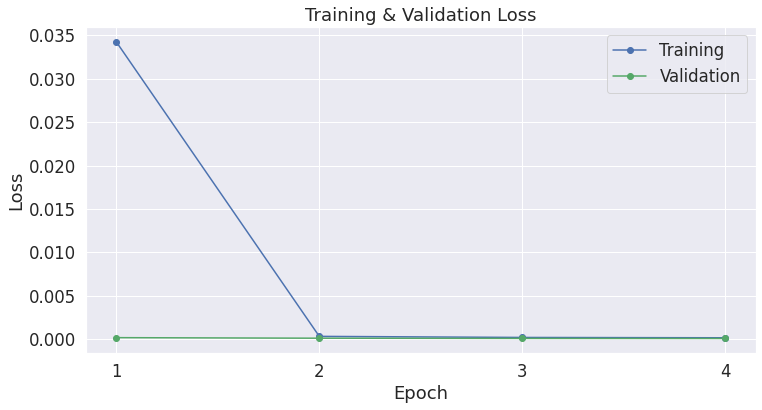

In [24]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# 5. Performance On Test Set

In [25]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

NameError: ignored